In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from scapy.all import rdpcap, IP, TCP, UDP
from ipaddress import ip_address
from datetime import datetime

In [2]:
packets = rdpcap('scan.pcap')

In [3]:
# Extract relevant fields from packets
packet_data = []
for pkt in packets:
    if IP in pkt:
        pkt_info = {
            'src_ip': pkt[IP].src,
            'dst_ip': pkt[IP].dst,
            'protocol': pkt[IP].proto,
            'timestamp': pkt.time,
            'length': len(pkt)
        }
        if TCP in pkt:
            pkt_info.update({
                'src_port': pkt[TCP].sport,
                'dst_port': pkt[TCP].dport,
                'protocol_type': 'TCP'
            })
        elif UDP in pkt:
            pkt_info.update({
                'src_port': pkt[UDP].sport,
                'dst_port': pkt[UDP].dport,
                'protocol_type': 'UDP'
            })
        packet_data.append(pkt_info)

In [4]:
df = pd.DataFrame(packet_data)
df.to_csv('packet_data.csv', index=False)
df.head()

,src_ip,dst_ip,protocol,timestamp,length,src_port,dst_port,protocol_type
0,52.182.143.208,192.168.0.123,6,1722603830.825889,66,443.0,53133.0,TCP
1,192.168.0.123,35.186.224.40,6,1722603831.041389,82,52427.0,443.0,TCP
2,35.186.224.40,192.168.0.123,6,1722603831.180497,54,443.0,52427.0,TCP
3,35.186.224.40,192.168.0.123,6,1722603831.219985,78,443.0,52427.0,TCP
4,192.168.0.123,35.186.224.40,6,1722603831.265190,54,52427.0,443.0,TCP


In [5]:
# Display a sample of both TCP and UDP packets
print("Sample TCP packets:")
print(df[df['protocol_type'] == 'TCP'].head())

print("\nSample UDP packets:")
print(df[df['protocol_type'] == 'UDP'].head())

Sample TCP packets:
           src_ip         dst_ip  protocol          timestamp  length  \
0  52.182.143.208  192.168.0.123         6  1722603830.825889      66   
1   192.168.0.123  35.186.224.40         6  1722603831.041389      82   
2   35.186.224.40  192.168.0.123         6  1722603831.180497      54   
3   35.186.224.40  192.168.0.123         6  1722603831.219985      78   
4   192.168.0.123  35.186.224.40         6  1722603831.265190      54   

   src_port  dst_port protocol_type  
0     443.0   53133.0           TCP  
1   52427.0     443.0           TCP  
2     443.0   52427.0           TCP  
3     443.0   52427.0           TCP  
4   52427.0     443.0           TCP  

Sample UDP packets:
         src_ip           dst_ip  protocol          timestamp  length  \
6   192.168.1.1  239.255.255.250        17  1722603832.541649     307   
7   192.168.1.1  239.255.255.250        17  1722603832.541649     316   
8   192.168.1.1  239.255.255.250        17  1722603832.541649     379   


In [6]:
# Verify the number of TCP and UDP packets
tcp_packets = df[df['protocol_type'] == 'TCP']
udp_packets = df[df['protocol_type'] == 'UDP']

print(f"Number of TCP packets: {len(tcp_packets)}")
print(f"Number of UDP packets: {len(udp_packets)}")

Number of TCP packets: 2142
Number of UDP packets: 948


In [7]:
# Convert timestamp to float and then to datetime
df['timestamp'] = df['timestamp'].astype(float)
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [8]:
# Top Talkers
top_talkers_src = df['src_ip'].value_counts().head(20)
top_talkers_dst = df['dst_ip'].value_counts().head(20)

In [9]:
# Print Top Talkers
print("\nTop 20 Source IPs:")
print(top_talkers_src)

print("\nTop 20 Destination IPs:")
print(top_talkers_dst)


Top 20 Source IPs:
src_ip
192.168.0.123      1426
192.168.0.1         187
192.168.1.1         171
35.186.224.22       151
52.37.252.164       149
157.240.242.61      117
35.186.224.24       115
35.186.224.40        93
13.107.5.93          63
157.240.237.60       53
163.70.143.60        52
157.240.242.60       47
192.168.0.126        46
35.163.196.185       44
199.232.210.248      32
54.213.189.120       29
44.224.90.130        29
192.168.0.145        20
20.247.184.197       19
20.190.145.160       19
Name: count, dtype: int64

Top 20 Destination IPs:
dst_ip
192.168.0.123      1348
239.255.255.250     317
35.186.224.22       149
52.37.252.164       129
35.186.224.24       112
157.240.242.61      109
35.186.224.40        93
157.240.237.60       77
192.168.0.1          76
224.0.0.251          61
163.70.143.60        60
13.107.5.93          58
157.240.242.60       54
35.163.196.185       47
199.232.210.248      30
54.213.189.120       30
20.247.184.197       26
192.168.0.255        26
44.

In [10]:
# Protocol Distribution
protocol_distribution = df['protocol_type'].value_counts()

In [11]:
# Traffic Volume Over Time
traffic_over_time = df.set_index('timestamp').resample('min').size()

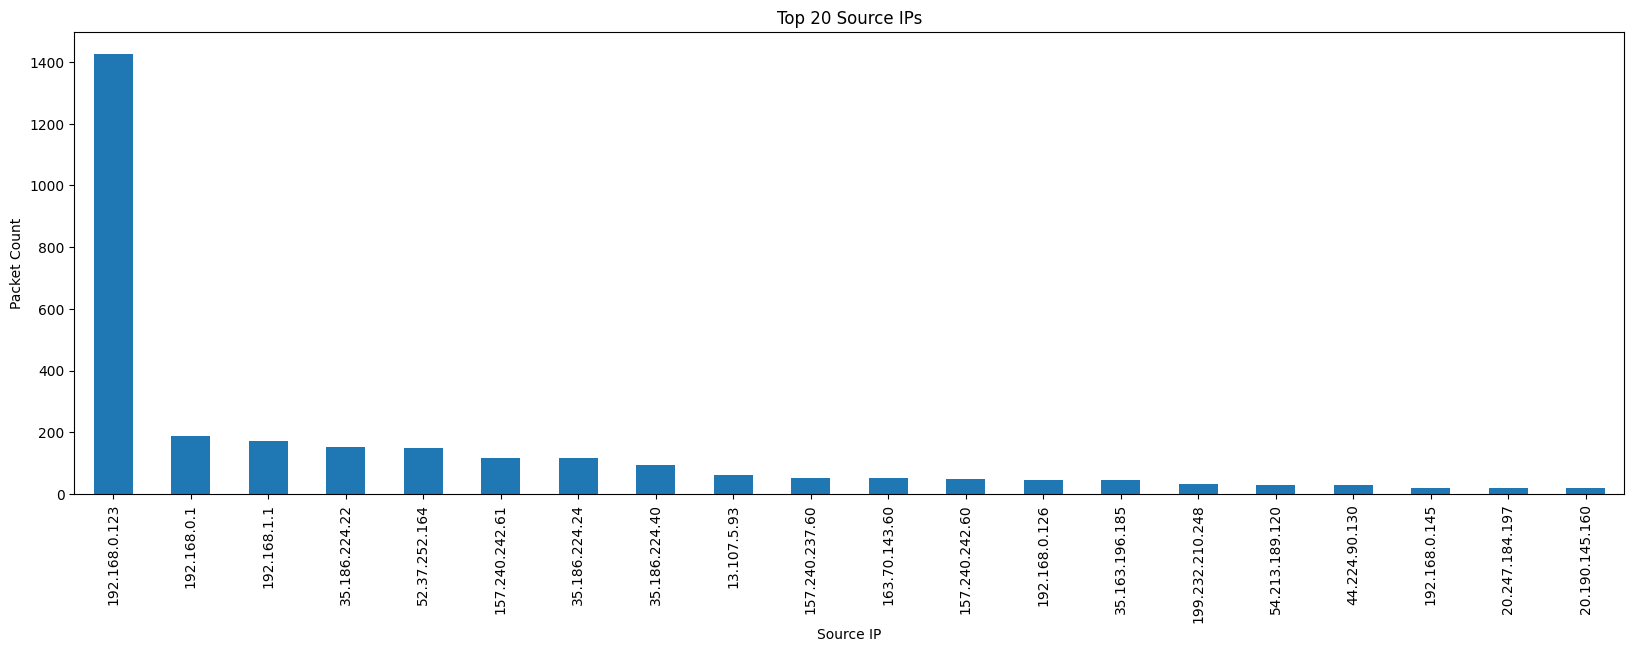

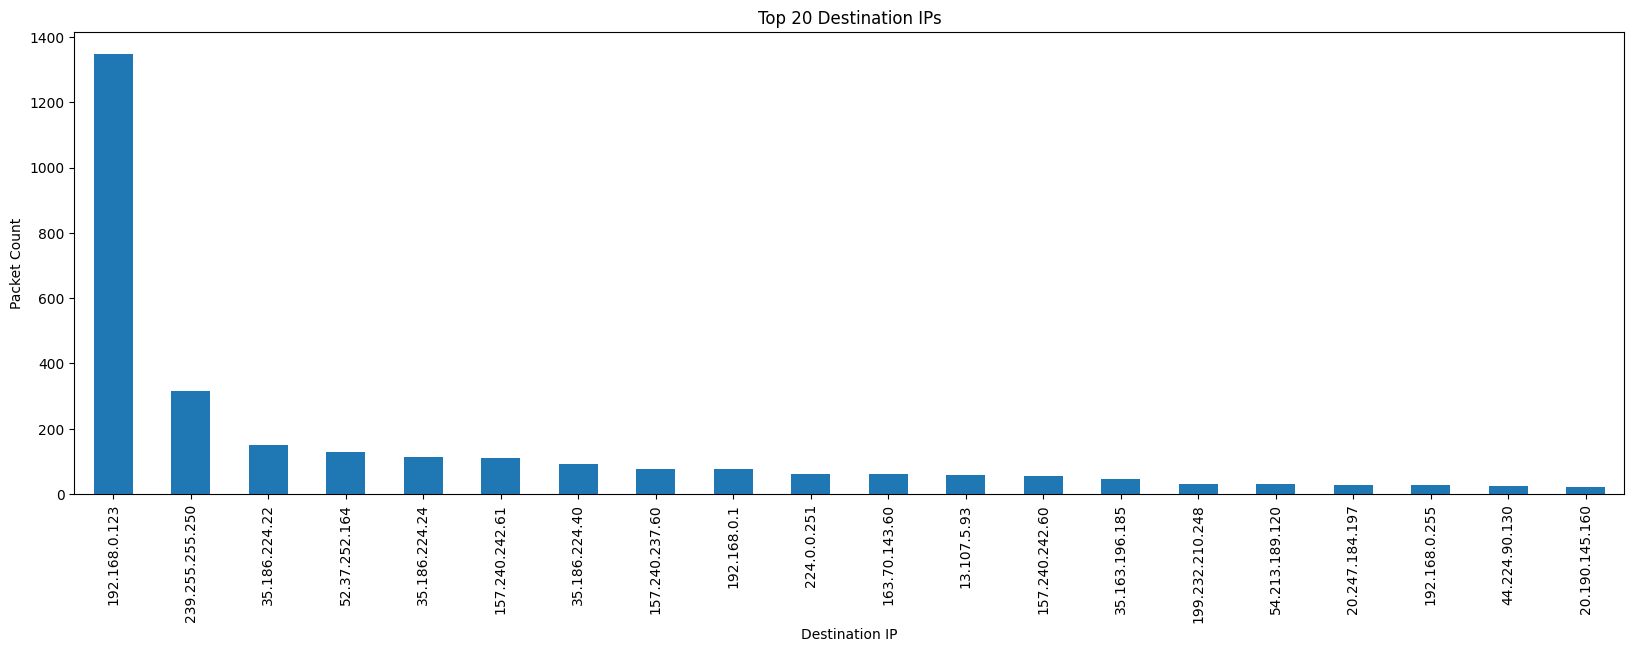

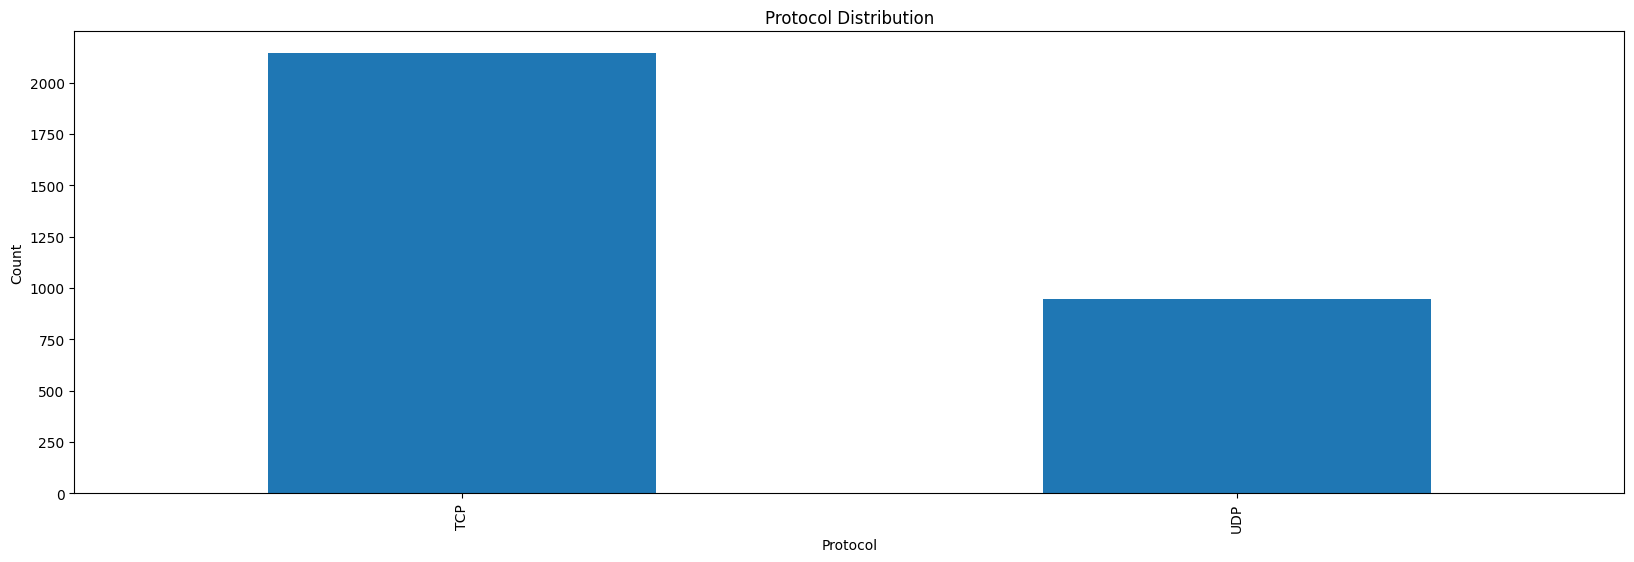

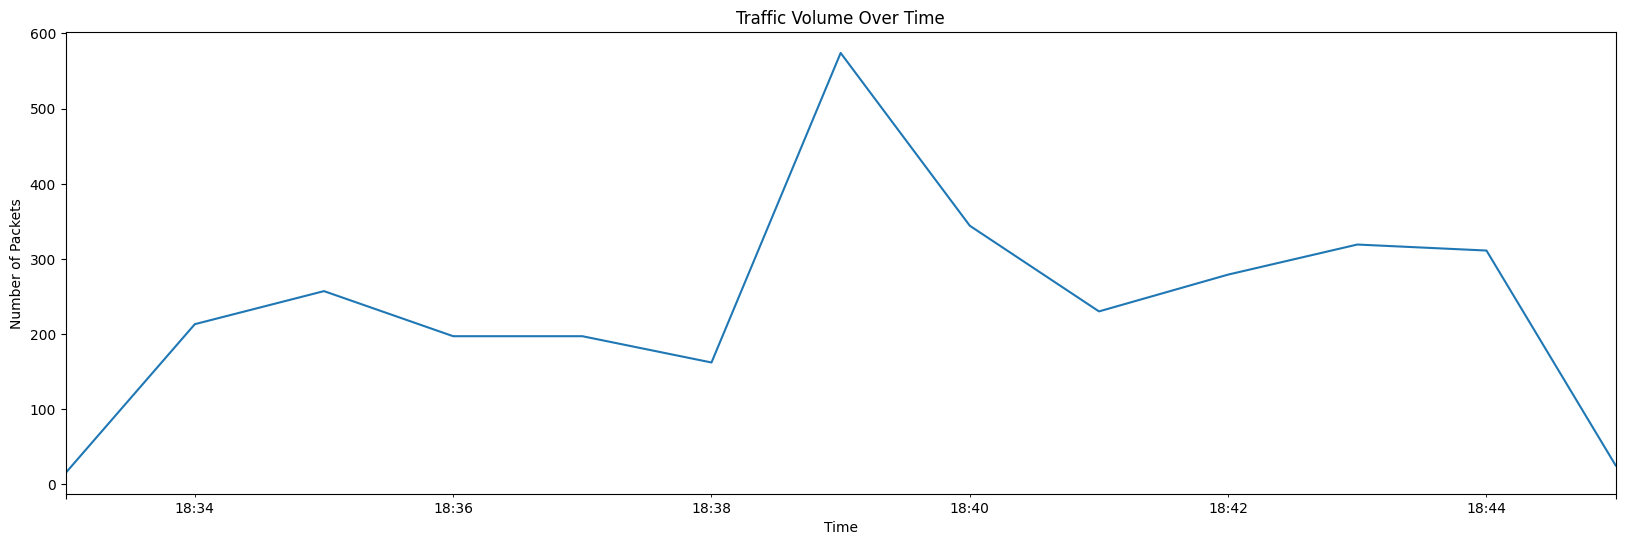

In [12]:
# Visualization
plt.figure(figsize=(20, 6))
top_talkers_src.plot(kind='bar', title='Top 20 Source IPs')
plt.xlabel('Source IP')
plt.ylabel('Packet Count')
plt.show()

plt.figure(figsize=(20, 6))
top_talkers_dst.plot(kind='bar', title='Top 20 Destination IPs')
plt.xlabel('Destination IP')
plt.ylabel('Packet Count')
plt.show()

plt.figure(figsize=(20, 6))
protocol_distribution.plot(kind='bar', title='Protocol Distribution')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(20, 6))
traffic_over_time.plot(title='Traffic Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Packets')
plt.show()

In [13]:
# Use the most active IPs as known malicious IPs
known_malicious_ips = list(top_talkers_src.index) + list(top_talkers_dst.index)

In [14]:
def detect_known_threats(df):
    threats = df[df['src_ip'].isin(known_malicious_ips) | df['dst_ip'].isin(known_malicious_ips)]
    return threats

In [15]:
detected_threats = detect_known_threats(df)
print("Detected threats:\n", detected_threats)

Detected threats:
               src_ip           dst_ip  protocol                  timestamp  \
0     52.182.143.208    192.168.0.123         6 2024-08-02 18:33:50.825889   
1      192.168.0.123    35.186.224.40         6 2024-08-02 18:33:51.041389   
2      35.186.224.40    192.168.0.123         6 2024-08-02 18:33:51.180497   
3      35.186.224.40    192.168.0.123         6 2024-08-02 18:33:51.219985   
4      192.168.0.123    35.186.224.40         6 2024-08-02 18:33:51.265190   
...              ...              ...       ...                        ...   
3118   192.168.0.123    35.186.224.40         6 2024-08-02 18:45:13.222390   
3119   192.168.0.123    192.168.0.255        17 2024-08-02 18:45:13.517609   
3120   192.168.0.123  239.255.255.250        17 2024-08-02 18:45:13.580368   
3121   192.168.0.123  239.255.255.250        17 2024-08-02 18:45:14.591507   
3122   192.168.0.123  239.255.255.250        17 2024-08-02 18:45:15.600014   

      length  src_port  dst_port protocol_ty

In [16]:
# Prepare data for anomaly detection
df['timestamp'] = df['timestamp'].apply(lambda x: int(x.timestamp()))  # Convert to Unix timestamp
df['src_ip_num'] = df['src_ip'].apply(lambda x: int(ip_address(x)))
df['dst_ip_num'] = df['dst_ip'].apply(lambda x: int(ip_address(x)))
feature_columns = ['src_ip_num', 'dst_ip_num', 'src_port', 'dst_port', 'timestamp']

In [17]:
# Drop rows with NaN values
df = df.dropna(subset=feature_columns)

In [18]:
# Train Isolation Forest model
model = IsolationForest(contamination=0.01)
model.fit(df[feature_columns])

,n_estimators,100
,max_samples,'auto'
,contamination,0.01
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,None
,verbose,0
,warm_start,False


In [19]:
# Predict anomalies
df['anomaly'] = model.predict(df[feature_columns])
anomalies = df[df['anomaly'] == -1]
print("Detected anomalies:\n", anomalies)

Detected anomalies:
              src_ip           dst_ip  protocol   timestamp  length  src_port  \
15    192.168.0.123      224.0.0.251        17  1722623640      69    5353.0   
17    192.168.0.123      224.0.0.251        17  1722623640      69    5353.0   
19    192.168.0.123    192.168.0.255        17  1722623641      92     137.0   
21    192.168.0.123      224.0.0.251        17  1722623641      69    5353.0   
22    192.168.0.123      224.0.0.251        17  1722623641      69    5353.0   
23    192.168.0.123    192.168.0.255        17  1722623641      92     137.0   
24    192.168.0.123    192.168.0.255        17  1722623642      92     137.0   
38    192.168.0.123      224.0.0.251        17  1722623646      87    5353.0   
39    192.168.0.123  239.255.255.250        17  1722623646     167   63853.0   
75    192.168.0.123    192.168.0.255        17  1722623652      86   57621.0   
82      192.168.0.1    192.168.0.123        17  1722623655     212      53.0   
162   192.168.0.123

In [20]:
# Save anomalies to CSV
anomalies.to_csv('anomalies.csv', index=False)

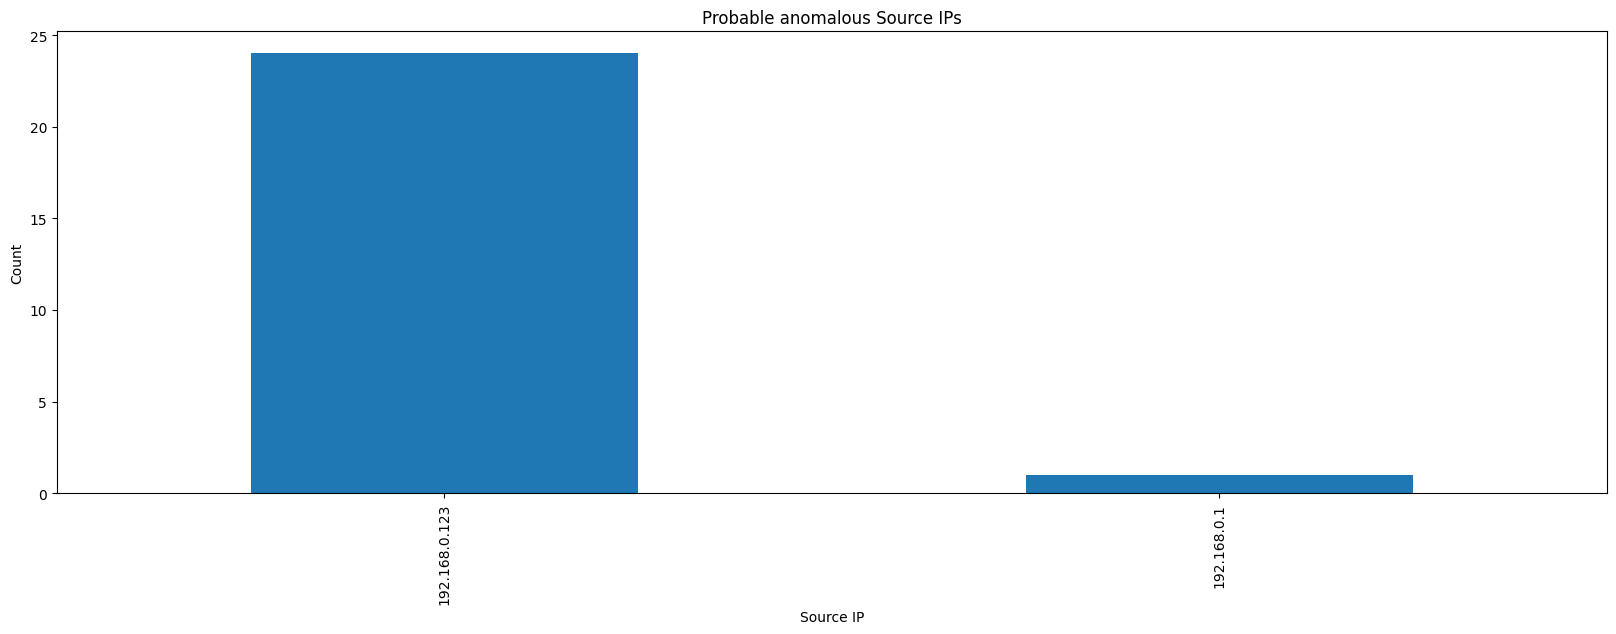

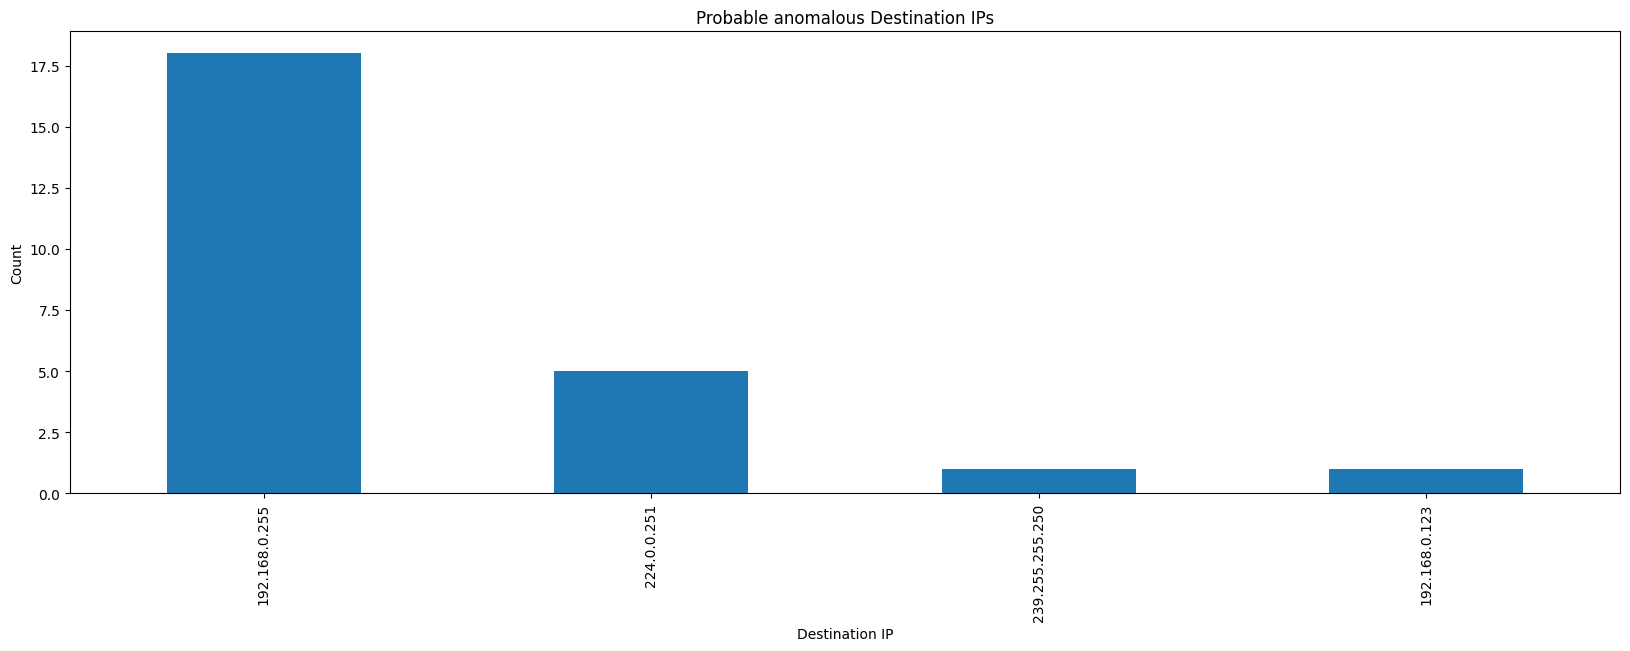

In [21]:
# Visualization of anomalies
plt.figure(figsize=(20, 6))
anomalies.set_index('timestamp')['src_ip'].value_counts().plot(kind='bar', title='Probable anomalous Source IPs')
plt.xlabel('Source IP')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(20, 6))
anomalies.set_index('timestamp')['dst_ip'].value_counts().plot(kind='bar', title='Probable anomalous Destination IPs')
plt.xlabel('Destination IP')
plt.ylabel('Count')
plt.show()